# Description

The notebook shows how to perform time series prediction using the Prophet model develop by Facebook.

References:
- White paper: `https://peerj.com/preprints/3190.pdf`
- Official docs: `https://facebook.github.io/prophet/docs/quick_start.html`

# Imports

In [1]:
# Install required libs on the fly.
!sudo /bin/bash -c "(source /venv/bin/activate; pip install prophet)"
!sudo /bin/bash -c "(source /venv/bin/activate; pip install plotly)"

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import prophet as prh
import prophet.utilities as prhu
import scipy.stats as stats

import helpers.hprint as hprint
import helpers.hdbg as hdbg
import helpers.hpandas as hpanda

In [4]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.12/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-6c6515f9-aff4-4434-91b5-9d809b43008b.json'


# Config

In [5]:
config = {
    # Train/test split.
    "train_start_date": "2020-01-01",
    "train_end_date": "2023-12-31",
    "test_start_date": "2024-01-01",
    "test_end_date": "2024-12-31",
    "data": {
        # Linear trend params.
        "slope": 0.005,
        "intercept": 15,
        # Fourier term params for seasonality component.
        "weekly_amp_sin": 5.0,
        "weekly_amp_cos": 2.5,
        # List of holidays and their impact.
        "holidays_dates": ['2020-12-25', '2021-12-25', '2022-12-25', "2023-12-25", "2024-12-25"],
        "holidays_impact": 2.5,
        # Autoregression params.
        "ar_order": 1,
        "phi": 0.7,
        # Noise std.
        "seed": 42,
        "noise_sigma": 2.0,
    },
    "model": {
        # Defines trend shape.
        "growth":"linear", 
        "yearly_seasonality":False, 
        # Integer defines Fourier order.
        "weekly_seasonality":1, 
        "daily_seasonality":False, 
        "n_changepoints":0, 
        # Prophet internally scales the target variable.
        "scaling":"minmax", 
        # Confidence iterval width.
        "interval_width":0.95,
        # Number of MCMC samples; If `mcmc_samples = 0`, the model produces just a point estimate  of each
        # parameter instead of the full distribution.
        "mcmc_samples":300,
        # Set lower prior scale to narrow the confidence interval.
        "holidays_prior_scale":1,
    },
}
print(config)

{'train_start_date': '2020-01-01', 'train_end_date': '2023-12-31', 'test_start_date': '2024-01-01', 'test_end_date': '2024-12-31', 'data': {'slope': 0.005, 'intercept': 15, 'weekly_amp_sin': 5.0, 'weekly_amp_cos': 2.5, 'holidays_dates': ['2020-12-25', '2021-12-25', '2022-12-25', '2023-12-25', '2024-12-25'], 'holidays_impact': 2.5, 'ar_order': 1, 'phi': 0.7, 'seed': 42, 'noise_sigma': 2.0}, 'model': {'growth': 'linear', 'yearly_seasonality': False, 'weekly_seasonality': 1, 'daily_seasonality': False, 'n_changepoints': 0, 'scaling': 'minmax', 'interval_width': 0.95, 'mcmc_samples': 300, 'holidays_prior_scale': 1}}


# Generate data

In [6]:
# Generate date range.
dates = pd.date_range(start=config["train_start_date"], end=config["test_end_date"], freq='D')
time = np.arange(len(dates))
# Define linear trend.
y_trend = config["data"]["slope"] * time + config["data"]["intercept"]
# Define the seasonality factor.
p_weekly = 7
y_weekly_seasonality = config["data"]["weekly_amp_sin"] * np.sin(2 * np.pi * time / p_weekly) + config["data"]["weekly_amp_cos"] * np.cos(2 * np.pi * time / p_weekly)
# Define holidays impact.
holiday_effect = np.zeros(len(dates))
holiday_effect[np.isin(dates.date, pd.to_datetime(config["data"]["holidays_dates"]).date)] = config["data"]["holidays_impact"]
# Define white noise.
np.random.seed(config["data"]["seed"])
noise = np.random.normal(loc=0, scale=config["data"]["noise_sigma"], size=len(time))
# Add autoregressive behavior.
y = np.zeros(len(time))
y[0] = y_trend[0] + y_weekly_seasonality[0] + holiday_effect[0] + noise[0]
for i in range(1, len(time)):
    y[i] = config["data"]["phi"] * y[i-1] + y_trend[i] + y_weekly_seasonality[i] + holiday_effect[i] + noise[i]
df = pd.DataFrame({"ds": dates, "y": y})
# Add lagged value of the target as a feature.
df["y.lag1"] = df["y"].shift(1)
# The first row is NaN -> drop it.
df = df.dropna()
_LOG.info(hpanda.df_to_str(df, log_level=logging.INFO))

,ds,y,y.lag1
1,2020-01-02 00:00:00,33.141753,18.493428
2,2020-01-03 00:00:00,43.822941,33.141753
3,2020-01-04 00:00:00,48.654115,43.822941
,...,...,...
1824,2024-12-29 00:00:00,78.387492,83.360033
1825,2024-12-30 00:00:00,74.449184,78.387492
1826,2024-12-31 00:00:00,71.713198,74.449184


INFO  None


<Axes: title={'center': 'Original data'}, xlabel='Time', ylabel='Target variable'>

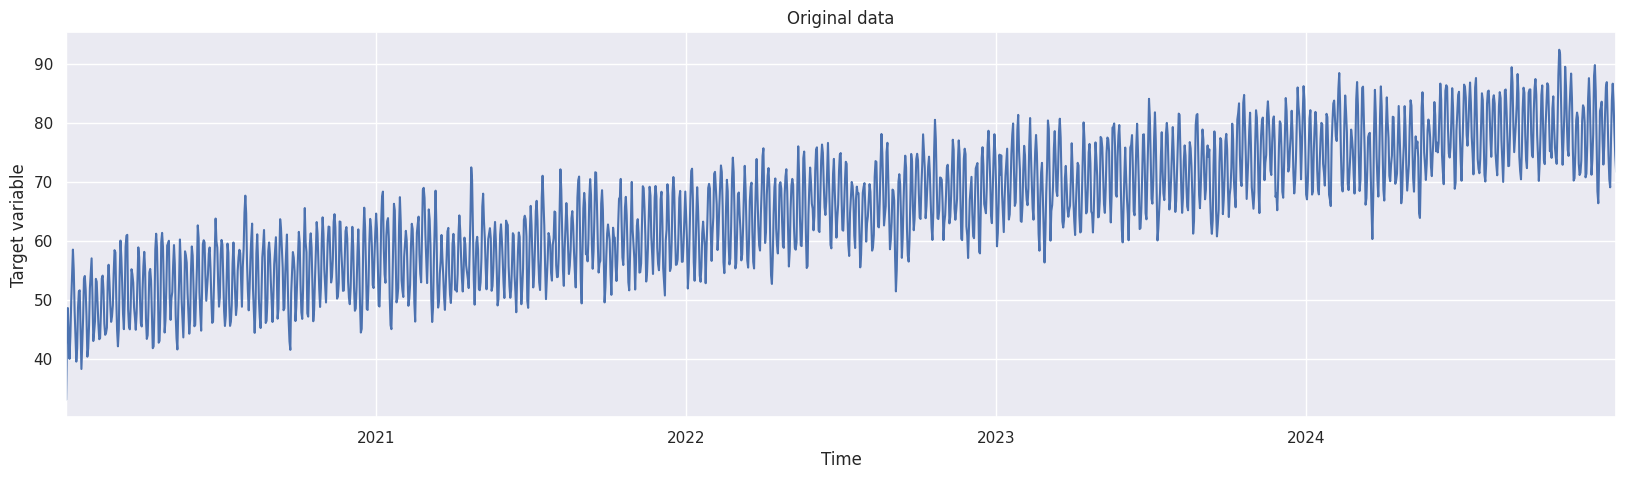

In [7]:
df.set_index("ds")["y"].plot(title="Original data", ylabel="Target variable", xlabel="Time")

# Fit the model

In [8]:
start_date_filter = df["ds"] >= config["train_start_date"]
end_date_filter = df["ds"] <= config["train_end_date"]
df_train = df[start_date_filter & end_date_filter]
_LOG.info(hpanda.df_to_str(df_train, log_level=logging.INFO))

,ds,y,y.lag1
1,2020-01-02 00:00:00,33.141753,18.493428
2,2020-01-03 00:00:00,43.822941,33.141753
3,2020-01-04 00:00:00,48.654115,43.822941
,...,...,...
1458,2023-12-29 00:00:00,86.189145,81.430431
1459,2023-12-30 00:00:00,83.89076,86.189145
1460,2023-12-31 00:00:00,76.324779,83.89076


INFO  None


In [9]:
# Construct a Dataframe with holidays.
holidays_df = pd.DataFrame({
    'holiday': ['Christmas 2020', 'Christmas 2021', 'Christmas 2022', "Christmas 2023", "Christmas 2024"],
    'ds': pd.to_datetime(config["data"]["holidays_dates"]),
    'lower_window': 0, 
    'upper_window': 0,   
})
_LOG.info(hpanda.df_to_str(holidays_df, log_level=logging.INFO))

,holiday,ds,lower_window,upper_window
0,Christmas 2020,2020-12-25,0,0
1,Christmas 2021,2021-12-25,0,0
2,Christmas 2022,2022-12-25,0,0
3,Christmas 2023,2023-12-25,0,0
4,Christmas 2024,2024-12-25,0,0


INFO  None


In [10]:
model = prh.Prophet(**config["model"], holidays=holidays_df)
# Explicitly add the lagged feature as an external regressor.
model.add_regressor('y.lag1')
model.fit(df_train)

21:35:43 - cmdstanpy - INFO - CmdStan start processing


INFO  CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

21:35:56 - cmdstanpy - INFO - CmdStan done processing.



INFO  CmdStan done processing.


21:35:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_gl

WARNING Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0

Dimensionality:
- k (Mx1 array): M posterior samples of the initial slope
- m (Mx1 array): The initial intercept
- delta (MxN array): The slope change at each of N changepoints
- beta (MxK matrix): Coefficients for K seasonality features
- sigma_obs (Mx1 array): Noise level
- M=1 (meaning that only the point estimate is available) if MAP estimation, i.e. `mcmc_samples=0` 

The number M (posterior samples) depends on:
- `mcmc_samples` provided by the user
- number of chains and the model internal mechanics that the user does not control
   - E.g., Prophet might be discarding some samples (e.g., through thinning) to reduce autocorrelation between the samples or to improve convergence

Scaling:
- Prophet perofrorms scaling internally, i.e. time is mapped to be on [0, 1] and Y is scaled by model.y_scale
- Where `y_scale` is controlled by the user and can be `absmax` or `minmax` scaling 
- TODO(Grisha): consider rescaling coefficients in order to compare them to the ground truth 

In [2]:
# TODO(Grisha): @Sonaal, can we apply some sort of the inverse-scaling transformation to the coefficients so that we can compare them to the original ones?

INFO  Shape of the intercept = (600,)
INFO  Intercept point estimate = 0.4776226516666666


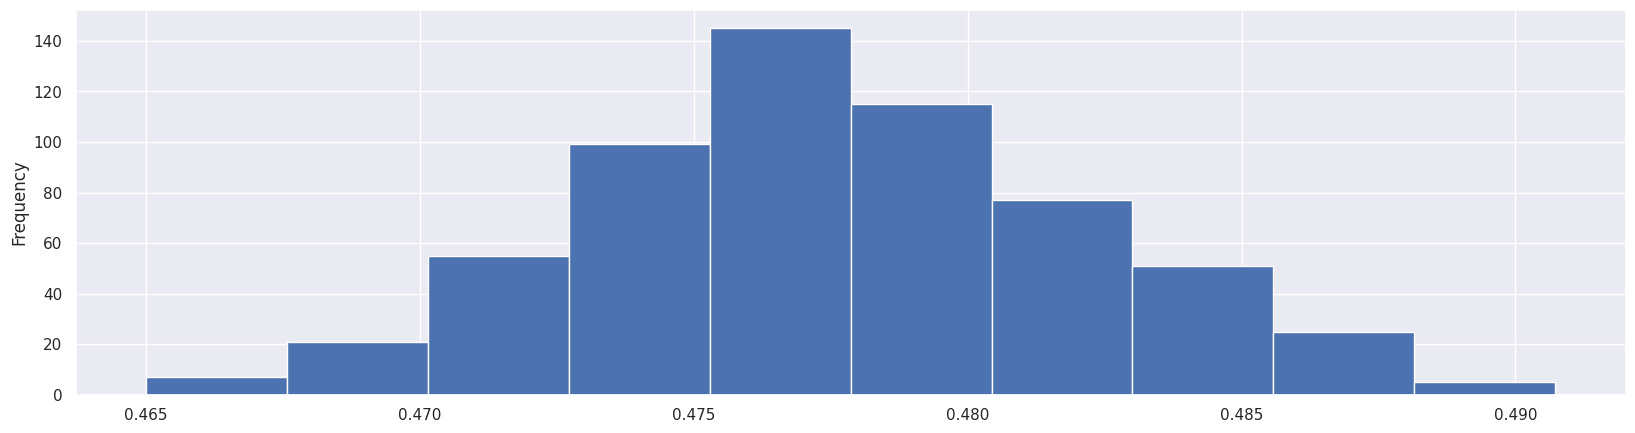

In [11]:
estimated_intercept = model.params["m"]
pd.Series(estimated_intercept).plot(kind="hist")
_LOG.info("Shape of the intercept = %s", estimated_intercept.shape)
_LOG.info("Intercept point estimate = %s", estimated_intercept.mean())

INFO  Shape of the intercept = (600,)
INFO  Intercept point estimate = 0.1481184653583333


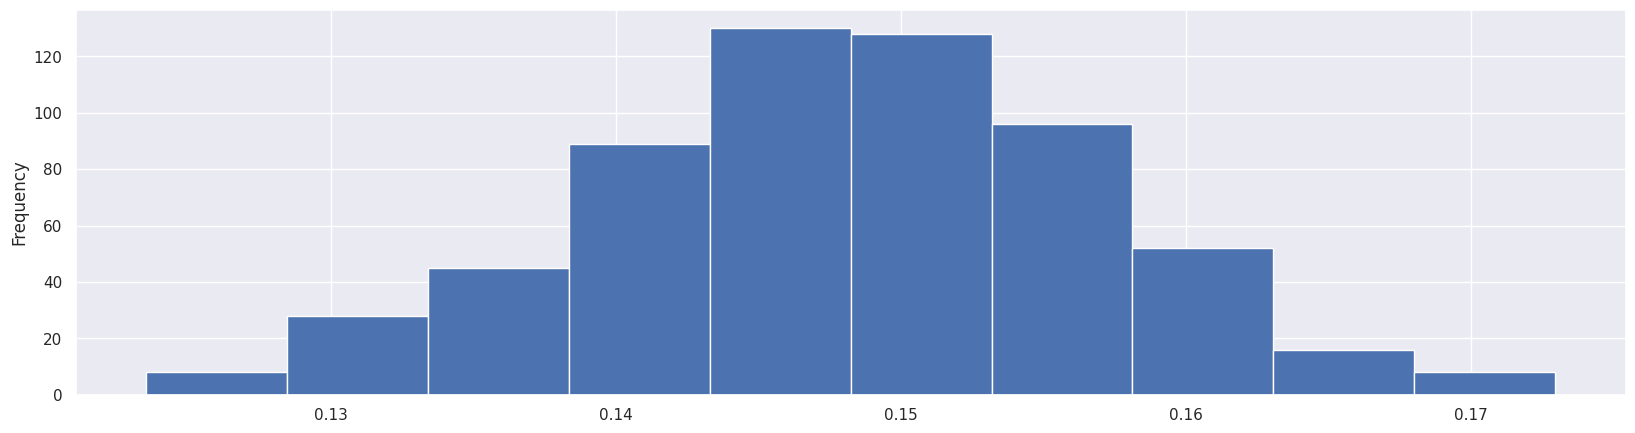

In [12]:
estimated_slope = model.params["k"]
pd.Series(estimated_slope).plot(kind="hist")
_LOG.info("Shape of the intercept = %s", estimated_slope.shape)
_LOG.info("Intercept point estimate = %s", estimated_slope.mean())

Estimated value of the autoregression coefficient is close to the ground truth.

In [13]:
# Use `regressor_coefficients()` to extract external regressors' coefficient. Unlike the other coeficients these
# already takes into account the internal scaling, thus can be directly compared to the original coefficients.
regressor_coefficients = prhu.regressor_coefficients(model)
_LOG.info(hpanda.df_to_str(regressor_coefficients, log_level=logging.INFO))
_LOG.info("True value of the autoregression coefficient = %s", config["data"]["phi"])

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,y.lag1,additive,62.375947,0.654235,0.689893,0.72531


INFO  None
INFO  True value of the autoregression coefficient = 0.7


Description:
- `weekly_delim_1` is the coefficient for the sine term
- `weekly_delim_2` is the coefficient for the cosine term
- in general the number of the Fourier coefficients is 2xN (i.e. 1 for the sine and 1 for the cosine), where N is Fourier order (i.e. 1 in our case)
- then we have 5 coefficients for 5 holidays
- and finally coefficients for the lagged feature
- each coefficient is a vector of length M (number of posterior samples)

Once the params are extracted:
- one can easily obtain a point estimate by averaging the values within a column
- compute confidence intervals using `np.quatile()`
- study the entire parameter's distribution

In [14]:
# Use this table to identify coefficients' indices in the regressors' matrix.
col_names = model.make_all_seasonality_features(df_train)[0].columns 
coefficients_df = pd.DataFrame(model.params["beta"], columns = col_names)
_LOG.info(hpanda.df_to_str(coefficients_df, log_level=logging.INFO))

,weekly_delim_1,weekly_delim_2,Christmas 2020_delim_+0,Christmas 2021_delim_+0,Christmas 2022_delim_+0,Christmas 2023_delim_+0,Christmas 2024_delim_+0,y.lag1
0,0.019702,0.10221,0.064665,0.078826,0.112681,0.040633,-0.620769,0.123735
1,0.028995,0.100154,0.049033,0.029053,0.047867,0.054683,0.053963,0.116658
2,0.025353,0.10313,0.036997,0.070537,0.070409,0.078967,0.590452,0.118976
,...,...,...,...,...,...,...,...
597,0.023537,0.101381,-0.022308,0.110703,-0.009991,0.120166,-0.068766,0.121756
598,0.018763,0.104761,0.076612,0.046141,0.152683,0.004859,0.229327,0.12677
599,0.027055,0.10194,-0.058719,0.046364,0.073653,-0.012803,1.08073,0.120644


INFO  None


# Predict

In [15]:
start_date_filter = df["ds"] >= config["test_start_date"]
end_date_filter = df["ds"] <= config["test_end_date"]
df_test = df[start_date_filter & end_date_filter].reset_index(drop=True)
_LOG.info(hpanda.df_to_str(df_test, log_level=logging.INFO))

,ds,y,y.lag1
0,2024-01-01 00:00:00,67.852807,76.324779
1,2024-01-02 00:00:00,67.038486,67.852807
2,2024-01-03 00:00:00,70.040899,67.038486
,...,...,...
363,2024-12-29 00:00:00,78.387492,83.360033
364,2024-12-30 00:00:00,74.449184,78.387492
365,2024-12-31 00:00:00,71.713198,74.449184


INFO  None


In [16]:
forecast = model.predict(df)
forecast = forecast.merge(df, how="inner", on=["ds"])
forecast["residual"] = forecast["y"] - forecast["yhat"]
_LOG.info(hpanda.df_to_str(forecast, log_level=logging.INFO))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas 2020,Christmas 2020_lower,Christmas 2020_upper,Christmas 2021,Christmas 2021_lower,Christmas 2021_upper,Christmas 2022,Christmas 2022_lower,Christmas 2022_upper,Christmas 2023,Christmas 2023_lower,Christmas 2023_upper,Christmas 2024,Christmas 2024_lower,Christmas 2024_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,y.lag1_x,y.lag1_lower,y.lag1_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,y.lag1_y,residual
0,2020-01-02 00:00:00,58.478389,29.488134,37.449349,58.031352,58.955867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-24.790806,-26.245936,-23.307659,-30.274251,-31.828449,-28.709496,0.0,0.0,0.0,5.483445,5.322665,5.632644,-30.274251,-31.828449,-28.709496,0.0,0.0,0.0,33.687582,33.141753,18.493428,-0.545829
1,2020-01-03 00:00:00,58.483774,38.514367,46.735363,58.037462,58.960679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-15.850751,-17.059275,-14.703966,-20.168472,-21.203866,-19.126044,0.0,0.0,0.0,4.31772,4.119956,4.509734,-20.168472,-21.203866,-19.126044,0.0,0.0,0.0,42.633023,43.822941,33.141753,1.189918
2,2020-01-04 00:00:00,58.48916,41.726982,49.480622,58.043573,58.965492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12.898928,-13.829912,-12.008173,-12.799592,-13.456689,-12.138033,0.0,0.0,0.0,-0.099336,-0.409445,0.192329,-12.799592,-13.456689,-12.138033,0.0,0.0,0.0,45.590232,48.654115,43.822941,3.063884
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,2024-12-29 00:00:00,68.295973,74.611434,82.213671,67.562596,68.98268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.035189,9.456555,10.632746,14.476779,13.728532,15.219977,0.0,0.0,0.0,-4.44159,-4.65079,-4.217154,14.476779,13.728532,15.219977,0.0,0.0,0.0,78.331161,78.387492,83.360033,0.05633
1824,2024-12-30 00:00:00,68.301358,70.252585,77.968686,67.567373,68.988559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.60702,5.012184,6.256942,11.046256,10.475319,11.613341,0.0,0.0,0.0,-5.439236,-5.581583,-5.27225,11.046256,10.475319,11.613341,0.0,0.0,0.0,73.908378,74.449184,78.387492,0.540806
1825,2024-12-31 00:00:00,68.306743,70.322135,78.090744,67.572151,68.994439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.988217,5.328184,6.665429,8.329244,7.898739,8.756845,0.0,0.0,0.0,-2.341027,-2.593767,-2.065103,8.329244,7.898739,8.756845,0.0,0.0,0.0,74.294961,71.713198,74.449184,-2.581763


INFO  None


# Analyze the results

In [5]:
# TODO(Grisha): @Sonaal, should we split into train/test sets manually or there is some built-in behavior that handles that?

In [17]:
ins_forecast = forecast[forecast["ds"]<=config["train_end_date"]]
ins_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas 2020,Christmas 2020_lower,Christmas 2020_upper,Christmas 2021,Christmas 2021_lower,Christmas 2021_upper,Christmas 2022,Christmas 2022_lower,Christmas 2022_upper,Christmas 2023,Christmas 2023_lower,Christmas 2023_upper,Christmas 2024,Christmas 2024_lower,Christmas 2024_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,y.lag1_x,y.lag1_lower,y.lag1_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,y.lag1_y,residual
1455,2023-12-27,66.314145,70.848545,78.189496,65.809405,66.778270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.081887,7.565484,8.614528,5.561863,5.274393,5.847394,0.0,0.0,0.0,2.520024,2.248193,2.801551,5.561863,5.274393,5.847394,0.0,0.0,0.0,74.396032,75.593189,70.437866,1.197157
1456,2023-12-28,66.319531,77.254086,84.859513,65.814179,66.784279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.601931,14.005203,15.149282,9.118486,8.647188,9.586604,0.0,0.0,0.0,5.483445,5.322665,5.632644,9.118486,8.647188,9.586604,0.0,0.0,0.0,80.921462,81.430431,75.593189,0.508970
1457,2023-12-29,66.324916,79.739725,87.810300,65.818952,66.790287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.463280,16.895041,18.024570,13.145559,12.466118,13.820417,0.0,0.0,0.0,4.317720,4.119956,4.509734,13.145559,12.466118,13.820417,0.0,0.0,0.0,83.788196,86.189145,81.430431,2.400949
1458,2023-12-30,66.330302,79.020746,86.755966,65.823726,66.796296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.329228,15.721670,16.935102,16.428563,15.579436,17.271961,0.0,0.0,0.0,-0.099336,-0.409445,0.192329,16.428563,15.579436,17.271961,0.0,0.0,0.0,82.659529,83.890760,86.189145,1.231231
1459,2023-12-31,66.335687,72.681345,80.496875,65.828453,66.802304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.401334,9.801007,11.019692,14.842924,14.075752,15.604919,0.0,0.0,0.0,-4.441590,-4.650790,-4.217154,14.842924,14.075752,15.604919,0.0,0.0,0.0,76.737021,76.324779,83.890760,-0.412241


<Axes: >

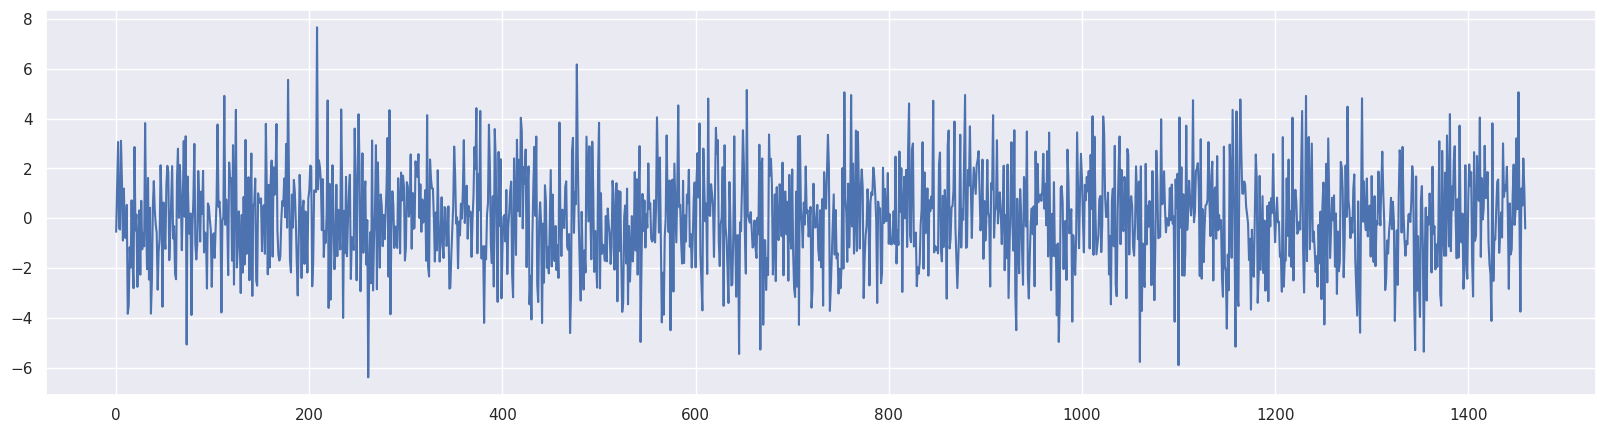

In [18]:
ins_forecast["residual"].plot()

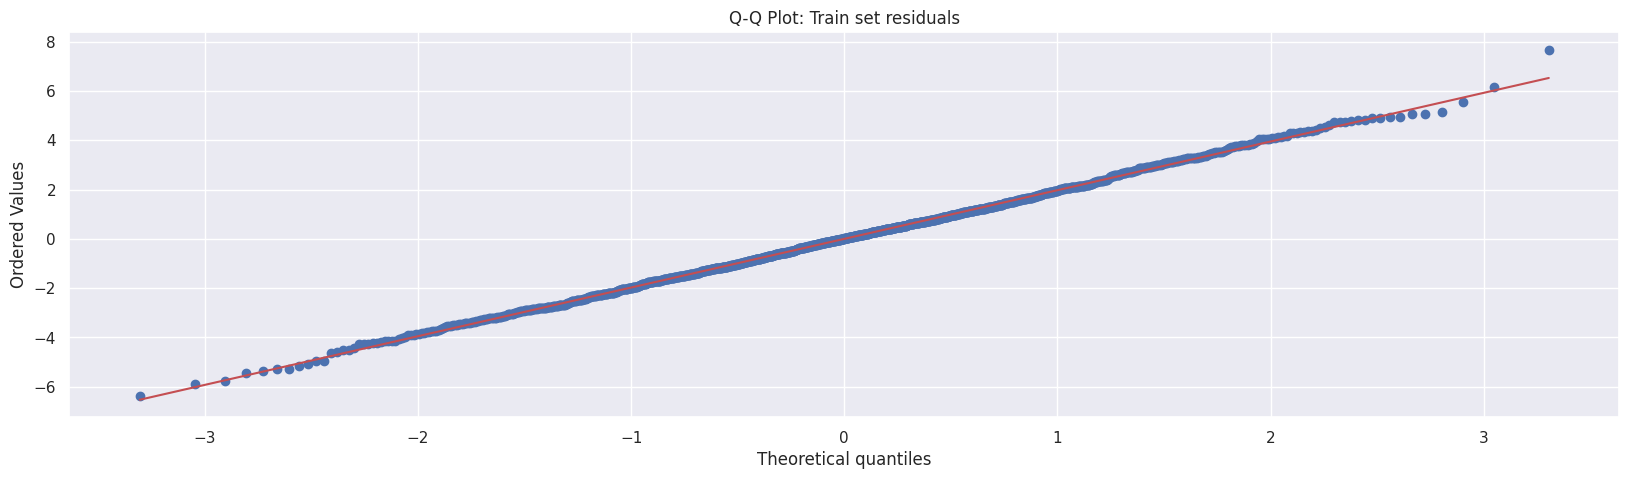

In [19]:
stats.probplot(ins_forecast["residual"], dist="norm", plot=plt)
plt.title("Q-Q Plot: Train set residuals")
plt.show()

Text(0.5, 1.0, 'Observed vs predicted data, train set')

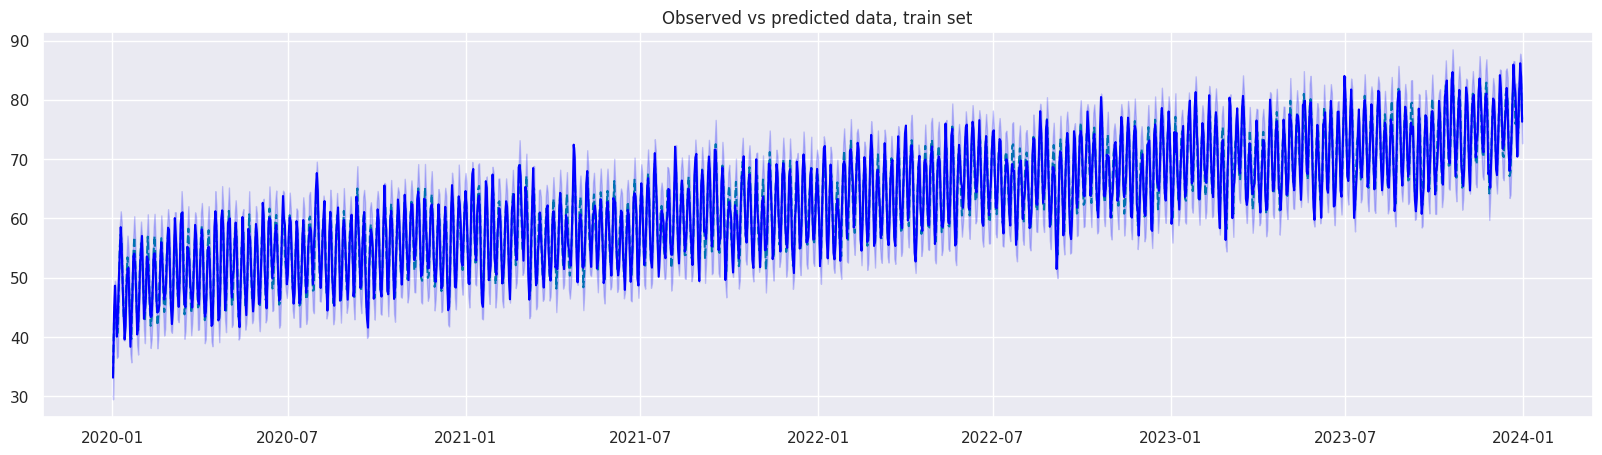

In [20]:
plt.plot(ins_forecast["ds"], ins_forecast["yhat"], label="Point Estimate", ls='--', c='#0072B2')
plt.plot(ins_forecast["ds"], ins_forecast["y"], label="Observed data", color="blue")

# Plot confidence/prediction intervals
plt.fill_between(
    ins_forecast["ds"],
    ins_forecast["yhat_lower"],
    ins_forecast["yhat_upper"],
    color="blue",
    alpha=0.2,
    label="Confidence Interval",
)
plt.title("Observed vs predicted data, train set")

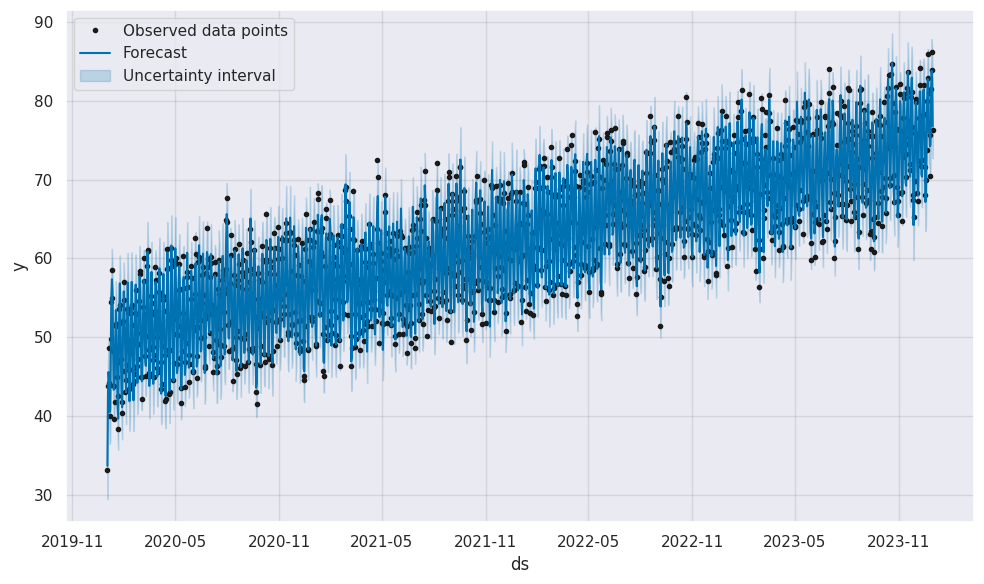

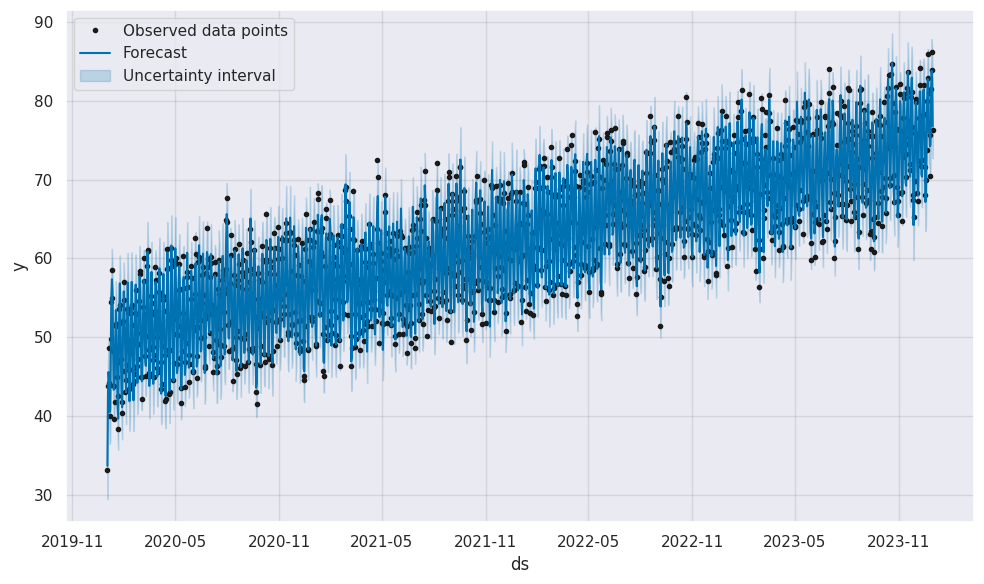

In [21]:
model.plot(ins_forecast, include_legend=True)

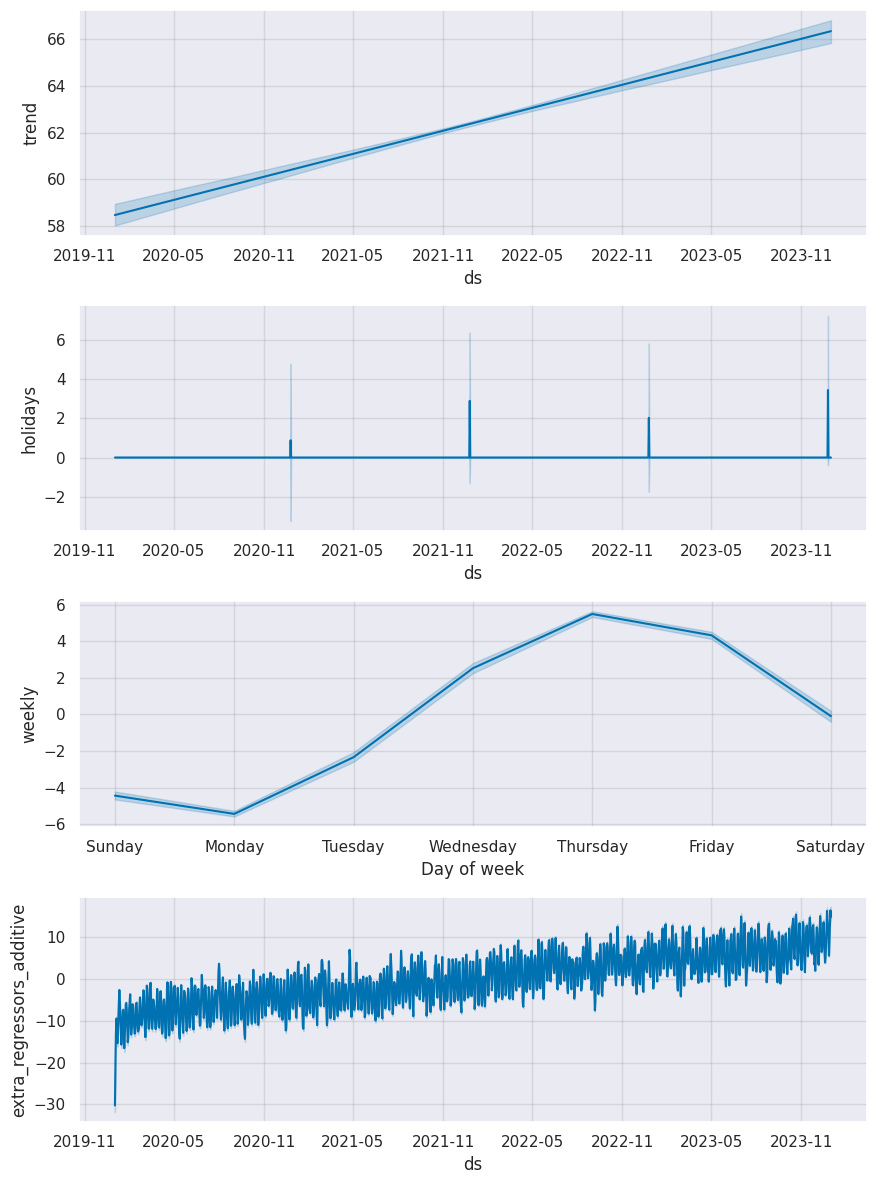

In [22]:
fig2 = model.plot_components(ins_forecast)

In [23]:
oos_forecast = forecast[forecast["ds"]>=config["test_start_date"]]
oos_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas 2020,Christmas 2020_lower,Christmas 2020_upper,Christmas 2021,Christmas 2021_lower,Christmas 2021_upper,Christmas 2022,Christmas 2022_lower,Christmas 2022_upper,Christmas 2023,Christmas 2023_lower,Christmas 2023_upper,Christmas 2024,Christmas 2024_lower,Christmas 2024_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,y.lag1_x,y.lag1_lower,y.lag1_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,y.lag1_y,residual
1821,2024-12-27,68.285202,83.342612,90.893647,67.553042,68.970920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.071284,18.421248,19.712396,14.753564,13.991011,15.510972,0.0,0.0,0.0,4.317720,4.119956,4.509734,14.753564,13.991011,15.510972,0.0,0.0,0.0,87.356486,86.611489,83.761234,-0.744997
1822,2024-12-28,68.290587,80.808697,88.975179,67.557819,68.976800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.620600,15.998949,17.241314,16.719936,15.855749,17.578292,0.0,0.0,0.0,-0.099336,-0.409445,0.192329,16.719936,15.855749,17.578292,0.0,0.0,0.0,84.911187,83.360033,86.611489,-1.551154
1823,2024-12-29,68.295973,74.611434,82.213671,67.562596,68.982680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.035189,9.456555,10.632746,14.476779,13.728532,15.219977,0.0,0.0,0.0,-4.441590,-4.650790,-4.217154,14.476779,13.728532,15.219977,0.0,0.0,0.0,78.331161,78.387492,83.360033,0.056330
1824,2024-12-30,68.301358,70.252585,77.968686,67.567373,68.988559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.607020,5.012184,6.256942,11.046256,10.475319,11.613341,0.0,0.0,0.0,-5.439236,-5.581583,-5.272250,11.046256,10.475319,11.613341,0.0,0.0,0.0,73.908378,74.449184,78.387492,0.540806
1825,2024-12-31,68.306743,70.322135,78.090744,67.572151,68.994439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.988217,5.328184,6.665429,8.329244,7.898739,8.756845,0.0,0.0,0.0,-2.341027,-2.593767,-2.065103,8.329244,7.898739,8.756845,0.0,0.0,0.0,74.294961,71.713198,74.449184,-2.581763


Text(0.5, 1.0, 'Observed vs predicted data, test set')

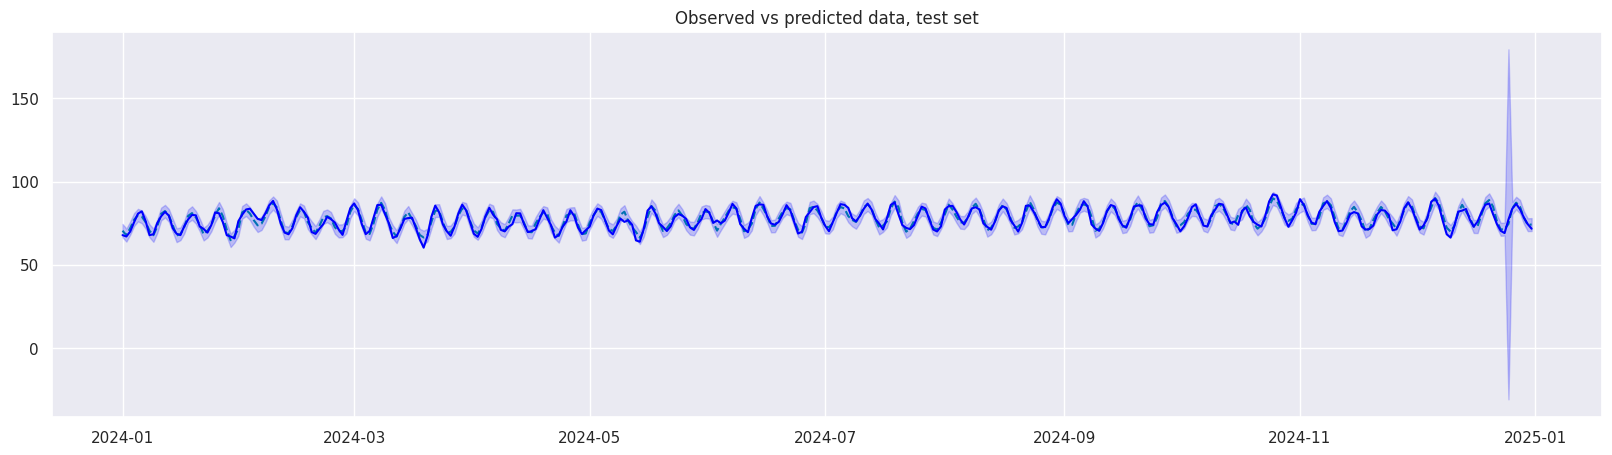

In [24]:
plt.plot(oos_forecast["ds"], oos_forecast["yhat"], label="Point Estimate", ls='--', c='#0072B2')
plt.plot(oos_forecast["ds"], oos_forecast["y"], label="Observed data", color="blue")

# Plot confidence/prediction intervals
plt.fill_between(
    oos_forecast["ds"],
    oos_forecast["yhat_lower"],
    oos_forecast["yhat_upper"],
    color="blue",
    alpha=0.2,
    label="Confidence Interval",
)
plt.title("Observed vs predicted data, test set")

In [3]:
# TODO(Grisha): @Sonaal,for the prediction can we add the actual data next to the forecast?
# TODO(Grisha): @Sonaal, should the CI become wider as the time advances? 

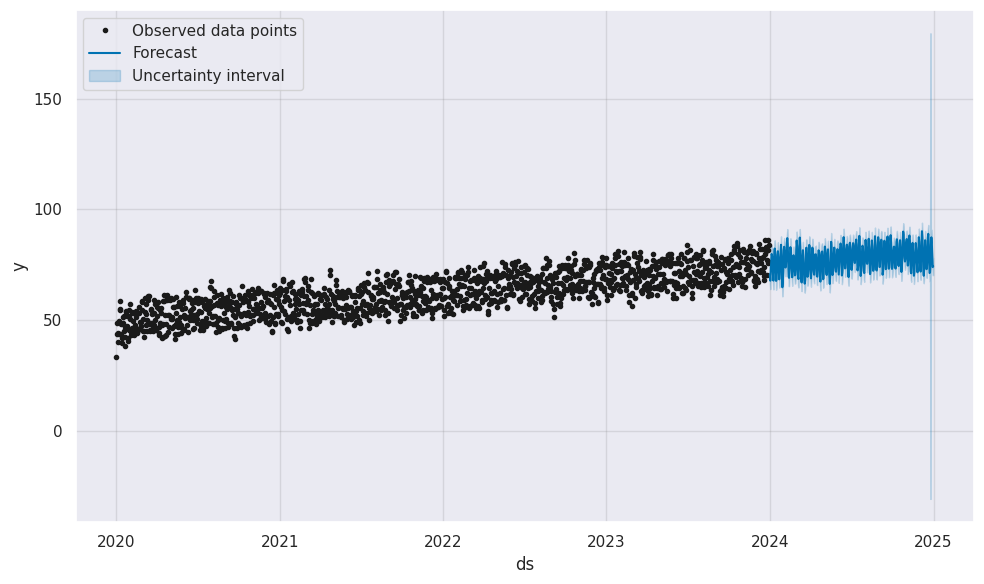

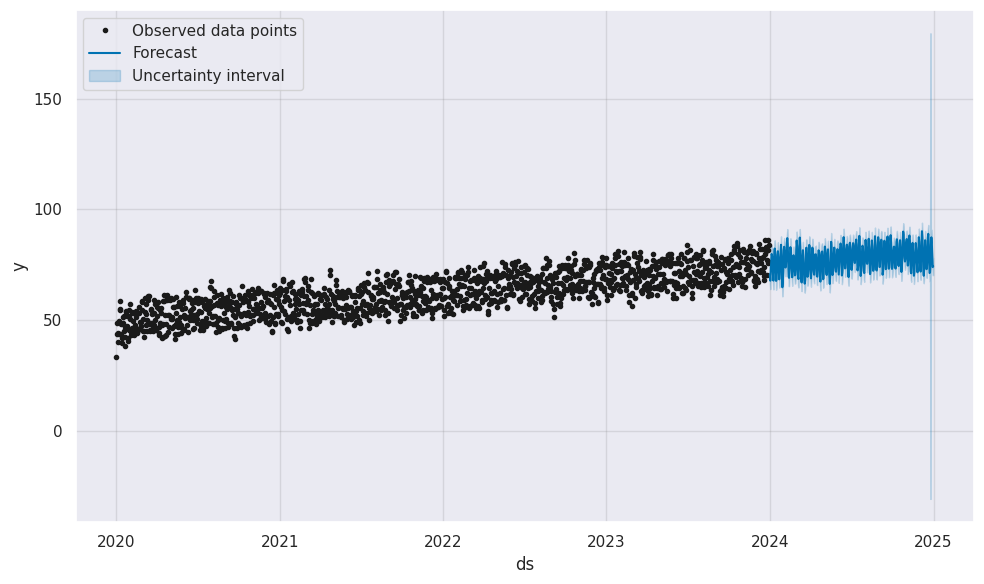

In [25]:
model.plot(oos_forecast, include_legend=True)

# Performance metrics

In [4]:
# TODO(Grisha): @Sonaal,can we use built-in tools to compute performance metrics? Can we also explain how it works.